In [224]:
%matplotlib notebook
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV 
from sklearn.cross_validation import cross_val_score
from sklearn import ensemble
import math

In [167]:
df = pd.read_csv("../Data Science/West Nile/train.csv")
weather = pd.read_csv("../Data Science/West Nile/weather.csv")
spray = pd.read_csv("../Data Science/West Nile/spray.csv")

In [168]:
df.head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [169]:
df['Address'].head(5)

0    4100 North Oak Park Avenue, Chicago, IL 60634,...
1    4100 North Oak Park Avenue, Chicago, IL 60634,...
2    6200 North Mandell Avenue, Chicago, IL 60646, USA
3      7900 West Foster Avenue, Chicago, IL 60656, USA
4      7900 West Foster Avenue, Chicago, IL 60656, USA
Name: Address, dtype: object

In [170]:
def extract_st(address):
    sid = address.split(",")[0].strip().split(" ")[0].strip()
    return sid

In [171]:
def extract_postal(address):
    postal = address.split(",")[2].strip().split(" ")[1].strip()
    return postal

In [172]:
df['sid'] = df['Address'].apply(extract_st)
#df['postal'] = df['Address'].apply(extract_postal) 

In [173]:
df.head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,sid
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,4100
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,4100
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,6200
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,7900
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,7900


In [174]:
df.drop("Address", axis=1, inplace=True)
df.drop("Street", axis=1, inplace=True)
df.drop("AddressNumberAndStreet", axis=1, inplace=True)

In [175]:
df['Latitude'] = df['Latitude'].apply(int)
df['Longitude'] = df['Longitude'].apply(int)

In [176]:
df.head(10)

,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,sid
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41,-87,9,1,0,4100
1,2007-05-29,CULEX RESTUANS,41,T002,41,-87,9,1,0,4100
2,2007-05-29,CULEX RESTUANS,62,T007,41,-87,9,1,0,6200
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41,-87,8,1,0,7900
4,2007-05-29,CULEX RESTUANS,79,T015,41,-87,8,4,0,7900
5,2007-05-29,CULEX RESTUANS,15,T045,41,-87,8,2,0,1500
6,2007-05-29,CULEX RESTUANS,25,T046,41,-87,8,1,0,2500
7,2007-05-29,CULEX PIPIENS/RESTUANS,11,T048,41,-87,8,1,0,1100
8,2007-05-29,CULEX RESTUANS,11,T048,41,-87,8,2,0,1100
9,2007-05-29,CULEX RESTUANS,11,T049,41,-87,8,1,0,1100


In [177]:
def extract_month(date):
    date = str(date)
    return str(int(date.split("-")[1].strip()))

In [178]:
df['month'] = df['Date'].apply(extract_month)
#df.drop("Date", axis=1, inplace=True)
df.head(5)

,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,sid,month
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,T002,41,-87,9,1,0,4100,5
1,2007-05-29,CULEX RESTUANS,41,T002,41,-87,9,1,0,4100,5
2,2007-05-29,CULEX RESTUANS,62,T007,41,-87,9,1,0,6200,5
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,T015,41,-87,8,1,0,7900,5
4,2007-05-29,CULEX RESTUANS,79,T015,41,-87,8,4,0,7900,5


In [179]:
df.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.0,10506.000000,10506.000000,10506.000000
mean,35.687797,41.038930,-87.0,7.819532,12.853512,0.052446
std,24.339468,0.193438,0.0,1.452921,16.133816,0.222936
min,10.000000,41.000000,-87.0,3.000000,1.000000,0.000000
25%,12.000000,41.000000,-87.0,8.000000,2.000000,0.000000
50%,33.000000,41.000000,-87.0,8.000000,5.000000,0.000000
75%,52.000000,41.000000,-87.0,9.000000,17.000000,0.000000
max,98.000000,42.000000,-87.0,9.000000,50.000000,1.000000


In [180]:
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [181]:
describe_categorical(df)

,Date,Species,Trap,sid,month
count,10506,10506,10506,10506,10506
unique,95,7,136,69,6
top,2007-08-01,CULEX PIPIENS/RESTUANS,T900,South,8
freq,551,4752,750,1430,3751


In [182]:
df['month'] = df['month'].apply(int)
df['Species'] = pd.factorize(df['Species'])[0]
df['Trap']= pd.factorize(df['Trap'])[0]
df['sid'] = pd.factorize(df['sid'])[0]

In [183]:
df.head(5)

,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,sid,month
0,2007-05-29,0,41,0,41,-87,9,1,0,0,5
1,2007-05-29,1,41,0,41,-87,9,1,0,0,5
2,2007-05-29,1,62,1,41,-87,9,1,0,1,5
3,2007-05-29,0,79,2,41,-87,8,1,0,2,5
4,2007-05-29,1,79,2,41,-87,8,4,0,2,5


# Weather

In [184]:
weather.head(5)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [185]:
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)
print(weather.head(5))

   Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68     -1        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52     -1        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

     ...    CodeSum Depth Water1 SnowFall  PrecipTotal StnPressure SeaLevel  \
0    ...                0     -1      0.0         0.00       29.10    29.82   
1    ...               -1     -1       -1         0.00       29.18    29.82   
2    ...         BR     0     -1      0.0         0.00       29.38    30.09   
3    ...      BR HZ    -1     -1       -1         0.00       29.44    30.08   
4    ...                0     -1      0.0         0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7       

In [186]:
weather.drop("CodeSum", axis=1, inplace=True)

In [187]:
stasion1 = weather[weather['Station'] ==1]
stasion2 = weather[weather['Station'] ==2]
stasion1.head(5)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,Sunset,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,1849,0,-1,0.0,0.00,29.10,29.82,1.7,27,9.2
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,1850,0,-1,0.0,0.00,29.38,30.09,13.0,4,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,1851,0,-1,0.0,0.00,29.39,30.12,11.7,7,11.9
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,1852,0,-1,0.0,-1,29.31,30.05,10.4,8,10.8
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,1853,0,-1,0.0,-1,29.40,30.10,11.7,7,12.0


In [188]:
stasion1.drop('Station', axis=1, inplace=True)
stasion2.drop('Station', axis=1, inplace=True)

c:\users\stardust\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\stardust\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [189]:
weather = stasion1.merge(stasion2, on="Date")
weather.head(10)

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,Sunset_y,Depth_y,Water1_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,0448,...,-1,-1,-1,-1,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,...,-1,-1,-1,-1,0.00,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,...,-1,-1,-1,-1,0.00,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,...,-1,-1,-1,-1,0.00,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,...,-1,-1,-1,-1,-1,29.46,30.09,11.2,7,11.5
5,2007-05-06,68,49,59,4,30,46,6,0,0442,...,-1,-1,-1,-1,0.00,29.62,30.28,13.8,10,14.5
6,2007-05-07,83,47,65,10,41,54,0,0,0441,...,-1,-1,-1,-1,0.00,29.44,30.12,8.5,17,9.9
7,2007-05-08,82,54,68,12,58,62,0,3,0439,...,-1,-1,-1,-1,-1,29.36,30.02,2.5,8,5.4
8,2007-05-09,77,61,69,13,59,63,0,4,0438,...,-1,-1,-1,-1,0.02,29.28,29.93,3.9,7,5.9
9,2007-05-10,84,56,70,14,52,60,0,5,0437,...,-1,-1,-1,-1,0.00,29.26,29.91,2.0,9,3.9


In [190]:
weather.describe()

,Tmax_x,Tmin_x,DewPoint_x,Water1_x,ResultSpeed_x,ResultDir_x,Tmax_y,Tmin_y,DewPoint_y,Water1_y,ResultSpeed_y,ResultDir_y
count,1472.00000,1472.000000,1472.000000,1472.0,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.0,1472.000000,1472.00000
mean,75.97894,56.730978,53.377717,-1.0,6.987092,17.656250,76.353261,58.889946,53.538043,-1.0,6.934239,17.33356
std,11.50315,10.347907,10.670263,0.0,3.586353,10.222077,11.421482,10.306855,10.683121,0.0,3.589725,9.90345
min,42.00000,29.000000,22.000000,-1.0,0.100000,1.000000,41.000000,29.000000,23.000000,-1.0,0.300000,1.00000
25%,68.00000,49.000000,46.000000,-1.0,4.400000,7.000000,69.000000,51.000000,46.000000,-1.0,4.275000,8.00000
50%,78.00000,58.000000,54.000000,-1.0,6.400000,19.500000,78.000000,60.000000,55.000000,-1.0,6.500000,19.00000
75%,85.00000,65.000000,61.250000,-1.0,9.100000,26.000000,85.000000,67.000000,62.000000,-1.0,9.225000,24.00000
max,103.00000,82.000000,75.000000,-1.0,24.100000,36.000000,104.000000,83.000000,74.000000,-1.0,21.700000,36.00000


In [191]:
df = df.merge(weather, on="Date")
df.drop("Date", axis=1, inplace=True)
df.head(10)

,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,sid,month,...,Sunset_y,Depth_y,Water1_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,0,41,0,41,-87,9,1,0,0,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
1,1,41,0,41,-87,9,1,0,0,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
2,1,62,1,41,-87,9,1,0,1,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
3,0,79,2,41,-87,8,1,0,2,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
4,1,79,2,41,-87,8,4,0,2,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
5,1,15,3,41,-87,8,2,0,3,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
6,1,25,4,41,-87,8,1,0,4,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
7,0,11,5,41,-87,8,1,0,5,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
8,1,11,5,41,-87,8,2,0,5,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
9,1,11,6,41,-87,8,1,0,5,5,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4


In [192]:
df = df.convert_objects(convert_numeric=True)

c:\users\stardust\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [193]:
test = df.tail(1000)
test.head(5)

,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,sid,month,...,Sunset_y,Depth_y,Water1_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
9506,2,40,115,41,-87,8,36,0,25,8,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9507,0,91,18,41,-87,8,20,0,13,8,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9508,0,91,18,41,-87,8,50,0,13,8,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9509,2,91,18,41,-87,8,38,1,13,8,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9510,0,10,116,41,-87,9,11,0,61,8,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8


In [194]:
df = df[:-1000]
df.describe()

,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,sid,month,...,Sunset_y,Depth_y,Water1_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
count,9506.000000,9506.000000,9506.000000,9506.000000,9506.0,9506.000000,9506.000000,9506.000000,9506.000000,9506.000000,...,9506.0,9506.0,9506.0,9506.0,9506.000000,9506.000000,9506.000000,9506.000000,9506.000000,9506.000000
mean,0.884073,35.461182,68.140438,41.038923,-87.0,7.790659,12.749106,0.040080,29.096255,7.609089,...,-1.0,-1.0,-1.0,-1.0,0.036681,29.302442,29.946817,5.998096,17.638228,7.533894
std,0.967339,24.277950,38.836822,0.193421,0.0,1.469071,16.367211,0.196157,18.692469,1.077208,...,0.0,0.0,0.0,0.0,0.394987,0.114785,0.118505,2.990309,9.110814,2.538448
min,0.000000,10.000000,0.000000,41.000000,-87.0,3.000000,1.000000,0.000000,0.000000,5.000000,...,-1.0,-1.0,-1.0,-1.0,-1.000000,28.950000,29.590000,1.100000,1.000000,2.700000
25%,0.000000,12.000000,32.000000,41.000000,-87.0,8.000000,2.000000,0.000000,16.000000,7.000000,...,-1.0,-1.0,-1.0,-1.0,0.000000,29.230000,29.870000,3.600000,10.000000,6.000000
50%,1.000000,33.000000,75.000000,41.000000,-87.0,8.000000,4.000000,0.000000,24.000000,8.000000,...,-1.0,-1.0,-1.0,-1.0,0.000000,29.310000,29.950000,5.850000,19.000000,7.200000
75%,2.000000,52.000000,100.000000,41.000000,-87.0,9.000000,17.000000,0.000000,44.000000,8.000000,...,-1.0,-1.0,-1.0,-1.0,0.060000,29.390000,30.040000,8.200000,24.000000,9.000000
max,5.000000,98.000000,134.000000,42.000000,-87.0,9.000000,50.000000,1.000000,68.000000,10.000000,...,-1.0,-1.0,-1.0,-1.0,1.190000,29.650000,30.330000,15.400000,36.000000,16.300000


# XGBoost

In [195]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors], label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    print(cvresult)
    return alg

In [196]:
predictors = [x for x in df.columns if x not in ['WnvPresent']]
predictors

['Species',
 'Block',
 'Trap',
 'Latitude',
 'Longitude',
 'AddressAccuracy',
 'NumMosquitos',
 'sid',
 'month',
 'Tmax_x',
 'Tmin_x',
 'Tavg_x',
 'Depart_x',
 'DewPoint_x',
 'WetBulb_x',
 'Heat_x',
 'Cool_x',
 'Sunrise_x',
 'Sunset_x',
 'Depth_x',
 'Water1_x',
 'SnowFall_x',
 'PrecipTotal_x',
 'StnPressure_x',
 'SeaLevel_x',
 'ResultSpeed_x',
 'ResultDir_x',
 'AvgSpeed_x',
 'Tmax_y',
 'Tmin_y',
 'Tavg_y',
 'Depart_y',
 'DewPoint_y',
 'WetBulb_y',
 'Heat_y',
 'Cool_y',
 'Sunrise_y',
 'Sunset_y',
 'Depth_y',
 'Water1_y',
 'SnowFall_y',
 'PrecipTotal_y',
 'StnPressure_y',
 'SeaLevel_y',
 'ResultSpeed_y',
 'ResultDir_y',
 'AvgSpeed_y']


Model Report
Accuracy : 0.9642
AUC Score (Train): 0.951418


<IPython.core.display.Javascript object>


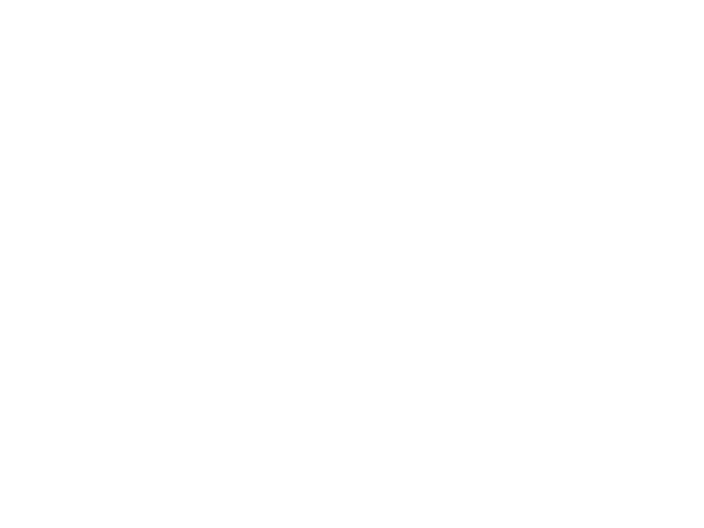

    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.737963      0.037572        0.767143       0.007413
1        0.801456      0.039580        0.829579       0.029353
2        0.822951      0.040865        0.852756       0.032151
3        0.837548      0.029728        0.865678       0.018351
4        0.841471      0.017974        0.879450       0.009925
5        0.849191      0.017580        0.886026       0.005571
6        0.852442      0.016598        0.890859       0.004016
7        0.854704      0.015433        0.894786       0.003723
8        0.858728      0.012610        0.897103       0.003696
9        0.860365      0.011571        0.899100       0.004197
10       0.862875      0.011148        0.901523       0.003889
11       0.860851      0.013534        0.903134       0.003029
12       0.863614      0.013301        0.904436       0.002613
13       0.862925      0.011050        0.905706       0.002569
14       0.863126      0.009827        0.906815       0

In [197]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=1,
 scale_pos_weight=1,
 seed=27)
clf = modelfit(xgb1, df, predictors, 'WnvPresent')

In [198]:
res = test['WnvPresent']
test.drop("WnvPresent", axis=1, inplace=True)

In [199]:
test.head(10)

,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,sid,month,Tmax_x,...,Sunset_y,Depth_y,Water1_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
9506,2,40,115,41,-87,8,36,25,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9507,0,91,18,41,-87,8,20,13,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9508,0,91,18,41,-87,8,50,13,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9509,2,91,18,41,-87,8,38,13,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9510,0,10,116,41,-87,9,11,61,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9511,0,10,116,41,-87,9,34,61,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9512,0,10,116,41,-87,9,24,61,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9513,0,10,116,41,-87,9,6,61,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9514,0,10,116,41,-87,9,35,61,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8
9515,1,10,116,41,-87,9,4,61,8,78,...,-1,-1,-1,-1,0.0,29.33,29.96,10.5,5,10.8


In [229]:
ypred = clf.predict_proba(test)[:,1]
ypred

array([ 0.197     ,  0.27575   ,  0.29351667,  0.195     ,  0.2126    ,
        0.348     ,  0.295     ,  0.108     ,  0.37      ,  0.06      ,
        0.21533333,  0.20633333,  0.04466667,  0.05066667,  0.067     ,
        0.118     ,  0.103     ,  0.4046    ,  0.32087227,  0.406     ,
        0.258     ,  0.125     ,  0.059     ,  0.085     ,  0.036     ,
        0.044     ,  0.308     ,  0.091     ,  0.075     ,  0.293     ,
        0.051     ,  0.077     ,  0.032     ,  0.18383333,  0.13166667,
        0.129     ,  0.052     ,  0.019     ,  0.30867934,  0.304     ,
        0.32827017,  0.092     ,  0.031     ,  0.25633333,  0.28790714,
        0.44666667,  0.32927083,  0.064     ,  0.027     ,  0.054     ,
        0.027     ,  0.00683333,  0.016     ,  0.05378087,  0.01197619,
        0.025     ,  0.023     ,  0.01583333,  0.03883333,  0.0675    ,
        0.006     ,  0.01275   ,  0.009     ,  0.032     ,  0.02708333,
        0.023     ,  0.05781667,  0.033     ,  0.06661874,  0.00

In [ ]:
res = res.as_matrix()

In [221]:
total = 0
co = 0
for i in ypred:
    total += math.pow((ypred[co] - res[co]), 2.0)
    co += 1
1 - (total / 1000.0)

0.829

In [226]:
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000)
clf.fit(df[predictors], df['WnvPresent'])
# create predictions and submission file
predictions = clf.predict_proba(test)[:,1]

In [227]:
total = 0
co = 0
for i in predictions:
    total += math.pow((predictions[co] - res[co]), 2.0)
    co += 1
1 - (total / 1000.0)

0.8583177350717628